In [26]:
import cv2
import numpy as np
import math
import glob, os


In [27]:
def _crop_to_signature(gray, thresh_val=220):
    # ... your code ...
    _, th = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)
    coords = cv2.findNonZero(th)
    if coords is None:
        return gray
    x, y, w, h = cv2.boundingRect(coords)
    return gray[y:y+h, x:x+w]

def _deskew(gray):
    # ... your code ...
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    coords = np.column_stack(np.where(th > 0))
    if coords.size == 0:
        return gray
    rect = cv2.minAreaRect(coords.astype(np.float32))
    angle = rect[-1]
    if angle < -45:
        angle = 90 + angle
    if abs(angle) < 1:
        return gray
    (h, w) = gray.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(gray, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    return rotated

def preprocess_signature(
    img_input,
    size=224,
    mean=0.5,
    std=0.5,
    deskew=True,
    crop=True,
    as_tensor=False
):
    # 1. Load image as grayscale
    if isinstance(img_input, str):
        gray = cv2.imread(img_input, cv2.IMREAD_GRAYSCALE)
        if gray is None:
            raise ValueError(f"Could not read image from path: {img_input}")
    else:
        img = img_input
        if len(img.shape) == 3 and img.shape[2] == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif len(img.shape) == 3 and img.shape[2] == 1:
            gray = img[:, :, 0]
        else:
            gray = img.copy()

    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    if crop:
        gray = _crop_to_signature(gray)

    if deskew:
        gray = _deskew(gray)

    h, w = gray.shape
    if h == 0 or w == 0:
        raise ValueError("Empty image encountered after cropping/deskewing.")

    scale = size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_AREA)

    h2, w2 = resized.shape
    pad_top = (size - h2) // 2
    pad_bottom = size - h2 - pad_top
    pad_left = (size - w2) // 2
    pad_right = size - w2 - pad_left

    padded = cv2.copyMakeBorder(
        resized,
        pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

    img_float = padded.astype(np.float32) / 255.0
    img_norm = (img_float - mean) / std

    if as_tensor:
        img_norm = np.expand_dims(img_norm, axis=0)  # (1,H,W)

    return img_norm


## Model

In [38]:

import tensorflow as tf
from tensorflow.keras import layers, models,Sequential
import tensorflow.keras.backend as K
import math


In [39]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim
        )
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)

        self.ffn = Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(num_heads * key_dim)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, x, training=False):
        attn = self.mha(x, x, x, training=training)
        attn = self.dropout1(attn, training=training)
        x = self.norm1(x + attn)

        ffn = self.ffn(x)
        ffn = self.dropout2(ffn, training=training)
        return self.norm2(x + ffn)


In [40]:
def build_cnn_transformer_embedding_model(
    input_shape=(128, 128, 1),
    embedding_dim=128,
    conv_filters=(32, 64, 128),
    transformer_layers=1,
    num_heads=4,
    key_dim=32,
    ff_dim=256,
    dropout=0.1
):
    """
    CNN + Transformer embedding backbone
    Output: L2-normalized embedding
    """

    inputs = layers.Input(shape=input_shape, name="signature_input")
    x = inputs

    # ----- CNN Backbone -----
    for f in conv_filters:
        x = layers.Conv2D(f, (3,3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D((2,2))(x)

    # x shape: (B, H', W', C)
    _, h, w, c = x.shape
    seq_len = h * w

    # ----- Flatten to tokens -----
    x = layers.Reshape((seq_len, c))(x)

    token_dim = num_heads * key_dim
    if c != token_dim:
        x = layers.Dense(token_dim, name="token_projection")(x)

    # ----- Transformer Encoder(s) -----
    for i in range(transformer_layers):
        x = TransformerEncoder(
            num_heads=num_heads,
            key_dim=key_dim,
            ff_dim=ff_dim,
            dropout=dropout,
            name=f"transformer_encoder_{i}"
        )(x)

    # ----- Pool tokens -----
    x = layers.GlobalAveragePooling1D()(x)

    # ----- Embedding Head -----
    x = layers.Dense(embedding_dim, use_bias=False, name="embedding_dense")(x)
    x = layers.BatchNormalization(name="embedding_bn")(x)
    x = layers.Lambda(
        lambda t: tf.math.l2_normalize(t, axis=1),
        name="l2_normalized_embedding"
    )(x)

    return models.Model(
        inputs=inputs,
        outputs=x,
        name="cnn_transformer_embedding_model"
    )


In [41]:
class ArcMarginProduct(layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.5, easy_margin=False, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def build(self, input_shape):
        embedding_dim = input_shape[0][-1]
        self.W = self.add_weight(
            name='W',
            shape=(embedding_dim, self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        embeddings, labels = inputs
        W = tf.nn.l2_normalize(self.W, axis=0)

        cos_theta = tf.matmul(embeddings, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7)

        sin_theta = tf.sqrt(1.0 - tf.square(cos_theta))
        cos_theta_m = cos_theta * self.cos_m - sin_theta * self.sin_m

        if self.easy_margin:
            cos_theta_m = tf.where(cos_theta > 0, cos_theta_m, cos_theta)
        else:
            cos_theta_m = tf.where(
                cos_theta > self.th,
                cos_theta_m,
                cos_theta - self.mm
            )

        one_hot = tf.one_hot(labels, depth=self.num_classes)
        logits = self.s * (one_hot * cos_theta_m + (1.0 - one_hot) * cos_theta)
        return logits


In [42]:
def build_cnn_transformer_arcface_training_model(
    num_classes,
    input_shape=(128, 128, 1),
    embedding_dim=128
):
    embedding_model = build_cnn_transformer_embedding_model(
        input_shape=input_shape,
        embedding_dim=embedding_dim,
        transformer_layers=1,     # start with 1
        num_heads=4,
        key_dim=32,
        ff_dim=256
    )

    image_input = layers.Input(shape=input_shape, name="image_input")
    label_input = layers.Input(shape=(), dtype=tf.int32, name="label_input")

    embeddings = embedding_model(image_input)

    logits = ArcMarginProduct(
        num_classes=num_classes,
        s=30.0,
        m=0.5
    )([embeddings, label_input])

    training_model = models.Model(
        inputs={"image_input": image_input, "label_input": label_input},
        outputs=logits,
        name="cnn_transformer_arcface_signature_model"
    )

    training_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    return training_model, embedding_model


In [43]:
import os
import glob

full_org_dir = "signatures/full_org"   # 🔴 change to your path

# get all images (png/jpg – adjust if needed)
image_paths = sorted(glob.glob(os.path.join(full_org_dir, "*.png")))

def parse_signer_id_from_filename(path):
    """
    Example:
      'original_1_1.png' -> signer 0
      'original_2_3.png' -> signer 1
    Pattern assumed: <prefix>_<signerId>_<sampleId>.png
    """
    fname = os.path.basename(path)       # 'original_1_1.png'
    parts = fname.split("_")             # ['original', '1', '1.png']
    signer_str = parts[1]                # '1'
    signer_int = int(signer_str) - 1     # make 0-based: 0,1,2,...
    return signer_int

labels = [parse_signer_id_from_filename(p) for p in image_paths]

num_classes = len(set(labels))
print("Total images:", len(image_paths))
print("Unique signers (classes):", num_classes)


Total images: 1320
Unique signers (classes): 55


In [45]:
# Convert lists → dataset
path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

def load_and_preprocess(path, label):
    def _preprocess(p):
        p = p.decode()
        img = preprocess_signature(p,size=128,as_tensor=True)
        return img.astype(np.float32)

    img = tf.numpy_function(_preprocess,[path],tf.float32)
    img.set_shape((128,128,1))
    label = tf.cast(label,tf.int32)

    return {"image_input":img,"label_input":label}, label

train_ds = (path_ds
            .shuffle(len(image_paths))
            .map(load_and_preprocess,num_parallel_calls=tf.data.AUTOTUNE)
            .batch(8)                          # small batch for CPU
            .prefetch(tf.data.AUTOTUNE))


In [46]:

# ---- Corrected mapping function ----
def load_and_preprocess(path, label):
    def _preprocess(path_bytes):
        # tf.string -> python str
        path_str = path_bytes.decode("utf-8")

        # call your existing preprocess_signature
        # it returns (1, H, W) when as_tensor=True in your implementation
        img = preprocess_signature(
            img_input=path_str,
            size=128,
            mean=0.5,
            std=0.5,
            deskew=True,
            crop=True,
            as_tensor=True  # returns shape (1, H, W)
        )

        # Ensure shape: convert (1, H, W) -> (H, W, 1)
        # sometimes preprocess returns (H,W) if as_tensor=False; handle both
        img = np.asarray(img)
        if img.ndim == 3 and img.shape[0] == 1:
            # (1, H, W) -> (H, W, 1)
            img = np.transpose(img, (1, 2, 0))
        elif img.ndim == 2:
            # (H, W) -> (H, W, 1)
            img = np.expand_dims(img, axis=-1)
        elif img.ndim == 3 and img.shape[-1] != 1:
            # e.g., (H, W, C) leave as is
            pass

        return img.astype(np.float32)

    # Wrap the numpy function for tf.data
    img = tf.numpy_function(_preprocess, [path], tf.float32)

    # IMPORTANT: set the static shape to (128,128,1)
    img.set_shape((128, 128, 1))

    label = tf.cast(label, tf.int32)

    # return inputs dict (as your model expects) and the target label
    return {"image_input": img, "label_input": label}, label

# ---- Recreate the dataset (use your existing image_paths, labels) ----
batch_size = 8

path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
train_ds = (
    path_ds
    .shuffle(buffer_size=len(image_paths))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# ---- Quick debug: fetch one batch and print shapes ----
for batch_inputs, batch_labels in train_ds.take(1):
    img_batch = batch_inputs["image_input"]
    print("img_batch.shape:", img_batch.shape)   # should be (batch_size, 128, 128, 1)
    print("label_batch.shape:", batch_labels.shape)


img_batch.shape: (8, 128, 128, 1)
label_batch.shape: (8,)


In [47]:
num_classes = 55
input_shape = (128,128,1)

training_model, embedding_model = build_cnn_transformer_arcface_training_model(
    num_classes=num_classes,
    input_shape=input_shape,
    embedding_dim=128
)

training_model.summary()

history = training_model.fit(
    train_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=5,
            restore_best_weights=True
        )
    ]
)


Model: "cnn_transformer_arcface_signature_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_transformer_em… │ (None, 128)       │    242,944 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arc_margin_product  │ (None, 55)        │      7,040 │ cnn_transformer_… │
│ (ArcMarginProduct)  │                   │            │ label_input[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 249,984 (976.50 KB)

 Trainable params: 249,280 (973.75 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 83s 426ms/step - accuracy: 0.0000e+00 - loss: 17.9478
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 397ms/step - accuracy: 0.0000e+00 - loss: 16.0224
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 72s 438ms/step - accuracy: 0.0045 - loss: 13.7180
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 90s 484ms/step - accuracy: 0.0341 - loss: 11.2827
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 83s 488ms/step - accuracy: 0.0856 - loss: 9.0788
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 55s 312ms/step - accuracy: 0.1727 - loss: 7.0118
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - accuracy: 0.2811 - loss: 5.2635
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 0.3462 - loss: 4.5537
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.4250 - loss: 3.4481
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.5371 - loss: 2.5934
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 55s 245ms/step - accuracy: 0.5674 - loss: 2.1888
Epoch 12/

In [48]:
# # 1. show model input info
# print("MODEL INPUTS:")
# for i, inp in enumerate(training_model.inputs):
#     print(i, inp.name, inp.shape, inp.dtype)

# print("\nMODEL SUMMARY:")
# training_model.summary()

# # 2. peek one element from dataset (not batched)
# # one = next(iter(path_ds))   # path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
# # print("\nExample path,label (raw):", one)

# # # 3. fetch one batch from train_ds and print shapes/dtypes/values
# # for batch_inputs, batch_labels in train_ds.take(1):
# #     # If dataset yields input dict:
# #     if isinstance(batch_inputs, dict):
# #         img_batch = batch_inputs.get("image_input") or batch_inputs.get("image")
# #         label_in = batch_inputs.get("label_input") or batch_inputs.get("label")
# #     else:
# #         # if it's a list/tuple of inputs, try ordering
# #         if isinstance(batch_inputs, (list, tuple)):
# #             img_batch = batch_inputs[0]
# #             label_in = batch_inputs[1] if len(batch_inputs)>1 else None
# #         else:
# #             print("Unknown batch_inputs type:", type(batch_inputs))
# #             img_batch = None
# #             label_in = None

# #     print("\nBATCH IMG shape:", None if img_batch is None else img_batch.shape, "dtype:", None if img_batch is None else img_batch.dtype)
# #     print("BATCH LABELS shape:", batch_labels.shape, "dtype:", batch_labels.dtype)
# #     # check label values range
# #     lb = batch_labels.numpy()
# #     print("label min, max:", lb.min(), lb.max())
# #     break


In [50]:


def get_embedding_from_model(image_path, embedding_model, size=128):
    # uses your preprocess_signature(img_path, size=..., as_tensor=True)
    img = preprocess_signature(img_input=image_path, size=size, as_tensor=True)
    img = np.asarray(img)
    # handle shape (1,H,W) -> (H,W,1)
    if img.ndim == 3 and img.shape[0] == 1:
        img = np.transpose(img, (1,2,0))
    elif img.ndim == 2:
        img = np.expand_dims(img, -1)
    X = np.expand_dims(img, axis=0).astype(np.float32)  # (1,H,W,1)
    emb = embedding_model.predict(X, verbose=0)[0]
    emb = emb / (np.linalg.norm(emb) + 1e-12)
    return emb


In [51]:
def sid_from_filename(path):
    # filenames like original_1_1.png -> signer id is middle token
    return int(os.path.basename(path).split("_")[1]) - 1

def build_db_means_from_folder(full_org_dir, embedding_model, size=128, batch_size=32):
    paths = sorted(glob.glob(os.path.join(full_org_dir, "*.png")))
    by_user = {}
    for p in paths:
        sid = sid_from_filename(p)
        emb = get_embedding_from_model(p, embedding_model, size=size)
        by_user.setdefault(sid, []).append(emb)

    user_ids = []
    means = []
    for uid in sorted(by_user.keys()):
        embs = np.vstack(by_user[uid])
        mean = embs.mean(axis=0)
        mean = mean / (np.linalg.norm(mean) + 1e-12)
        user_ids.append(uid)
        means.append(mean.astype(np.float32))

    means = np.vstack(means)  # (N_users, D)
    user_ids = np.array(user_ids, dtype=np.int32)
    return means, user_ids

# Example call (adjust path)
DB_MEANS, DB_USER_IDS = build_db_means_from_folder("signatures/full_org", embedding_model, size=128)
print("DB_MEANS.shape:", DB_MEANS.shape, "DB_USER_IDS.shape:", DB_USER_IDS.shape)


DB_MEANS.shape: (55, 128) DB_USER_IDS.shape: (55,)


In [52]:
def save_embeddings_npz(npz_path, means, user_ids):
    np.savez_compressed(npz_path, means=means.astype(np.float32), user_ids=user_ids.astype(np.int32))
    print("Saved:", npz_path)

def load_embeddings_npz(npz_path):
    z = np.load(npz_path)
    means = z["means"].astype(np.float32)
    user_ids = z["user_ids"].astype(np.int32)
    # ensure normalized
    means = means / (np.linalg.norm(means, axis=1, keepdims=True) + 1e-12)
    return means, user_ids

# Save:
save_embeddings_npz("embeddings.npz", DB_MEANS, DB_USER_IDS)

# Later load:
# DB_MEANS, DB_USER_IDS = load_embeddings_npz("embeddings.npz")


Saved: embeddings.npz


In [53]:
!pip install scikit-learn
from sklearn.metrics import roc_curve, roc_auc_score

def batch_get_embeddings(paths, embedding_model, size=128, batch_size=16):
    embs = []
    batch = []
    for p in paths:
        img = preprocess_signature(img_input=p, size=size, as_tensor=True)
        img = np.asarray(img)
        if img.ndim == 3 and img.shape[0] == 1:
            img = np.transpose(img,(1,2,0))
        elif img.ndim == 2:
            img = np.expand_dims(img, -1)
        batch.append(img.astype(np.float32))
        if len(batch) >= batch_size:
            X = np.stack(batch, axis=0)
            e = embedding_model.predict(X, verbose=0)
            embs.append(e)
            batch=[]
    if batch:
        X = np.stack(batch, axis=0)
        e = embedding_model.predict(X, verbose=0)
        embs.append(e)
    if len(embs)==0:
        return np.zeros((0, embedding_model.output_shape[-1]), dtype=np.float32)
    embs = np.vstack(embs)
    embs = embs / (np.linalg.norm(embs, axis=1, keepdims=True) + 1e-12)
    return embs

def compute_eer_threshold(full_org_dir, full_forg_dir, embedding_model, refs_per_user=3, size=128):
    # group paths
    org_paths = sorted(glob.glob(os.path.join(full_org_dir, "*.png")))
    forg_paths = sorted(glob.glob(os.path.join(full_forg_dir, "*.png")))
    org_by_sid = {}
    forg_by_sid = {}
    for p in org_paths:
        sid = sid_from_filename(p)
        org_by_sid.setdefault(sid, []).append(p)
    for p in forg_paths:
        sid = sid_from_filename(p)
        forg_by_sid.setdefault(sid, []).append(p)

    y_true = []
    y_scores = []
    for sid, paths in org_by_sid.items():
        if len(paths) < refs_per_user + 1:
            continue
        refs = paths[:refs_per_user]
        ref_embs = batch_get_embeddings(refs, embedding_model, size=size)
        ref_mean = np.mean(ref_embs, axis=0)
        ref_mean = ref_mean / (np.linalg.norm(ref_mean) + 1e-12)

        for test_p in paths[refs_per_user:]:
            emb = batch_get_embeddings([test_p], embedding_model, size=size)[0]
            score = float(np.dot(emb, ref_mean))
            y_scores.append(score); y_true.append(1)
        for f in forg_by_sid.get(sid, []):
            emb = batch_get_embeddings([f], embedding_model, size=size)[0]
            score = float(np.dot(emb, ref_mean))
            y_scores.append(score); y_true.append(0)

    if len(set(y_true)) < 2:
        raise RuntimeError("Not enough genuine/forged data to compute EER.")
    auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fnr - fpr))
    eer_thr = thresholds[eer_idx]
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2.0
    print(f"AUC={auc:.4f}, EER={eer:.4f}, EER_threshold={eer_thr:.4f}")
    return eer_thr, {"auc":auc, "eer":eer}

# Example (may take some time on CPU)
# thr, metrics = compute_eer_threshold("signatures/full_org", "signatures/full_forg", embedding_model, refs_per_user=3, size=128)
# print("Use threshold:", thr)



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
def predict_original_or_forged(image_path, embedding_model, db_means, db_user_ids, threshold=0.75, size=128):
    query_emb = get_embedding_from_model(image_path, embedding_model, size=size)
    sims = db_means @ query_emb   # vectorized cosine (means should be normalized)
    best_idx = int(np.argmax(sims))
    best_score = float(sims[best_idx])
    matched_user = int(db_user_ids[best_idx])
    if best_score >= threshold:
        return {"result":"ORIGINAL", "matched_user_id": matched_user, "score": best_score}
    else:
        return {"result":"FORGED", "matched_user_id": None, "score": best_score}


In [55]:
# increase layer and distane formula change 
def predict_with_margin(
    image_path,
    embedding_model,
    db_means,
    db_user_ids,
    sim_threshold=0.78,
    margin_threshold=0.05,
    size=128
):
    emb = get_embedding_from_model(image_path, embedding_model, size=size)
    sims = db_means @ emb

    sorted_idx = np.argsort(sims)[::-1]
    best = sims[sorted_idx[0]]
    second_best = sims[sorted_idx[1]]

    if best >= sim_threshold and (best - second_best) >= margin_threshold:
        return {
            "result": "ORIGINAL",
            "user": int(db_user_ids[sorted_idx[0]]),
            "best_score": float(best),
            "margin": float(best - second_best)
        }
    else:
        return {
            "result": "FORGED",
            "best_score": float(best),
            "margin": float(best - second_best)
        }


In [62]:
# load saved DB if needed
DB_MEANS, DB_USER_IDS = load_embeddings_npz("embeddings.npz")

# compute threshold once (recommended)
# thr, _ = compute_eer_threshold("signatures/full_org", "signatures/full_forg", embedding_model)

# quick test
res1 = predict_with_margin(
    "signatures/full_org/original_13_1.png",
    embedding_model,
    DB_MEANS,
    DB_USER_IDS,
    sim_threshold=0.89,      # ✅ correct name
    margin_threshold=0.07
)

res2 = predict_with_margin(
    "signatures/full_forg/forgeries_13_1.png",
    embedding_model,
    DB_MEANS,
    DB_USER_IDS,
    sim_threshold=0.88,      # ✅ forgery name
    margin_threshold=0.07
)

print(res1)
print(res2)

'''we can use  sim_threshold=0.88-0.95,    
    margin_threshold=0.04-0.08  '''

{'result': 'ORIGINAL', 'user': 12, 'best_score': 0.9499318599700928, 'margin': 0.31710588932037354}
{'result': 'FORGED', 'best_score': 0.7444943189620972, 'margin': 0.06659668684005737}


'we can use  sim_threshold=0.88-0.95,    \n    margin_threshold=0.04-0.08  '


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


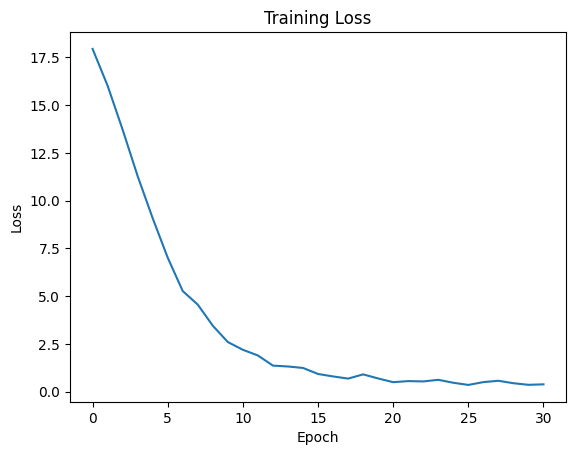

In [63]:
!pip install matplotlib
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()
